In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [2]:
#!pip install opencv-python

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import shutil
import imghdr

from glob import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [6]:
!nvidia-smi

Sat Dec  9 23:07:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We can see from the above output that Tensorflow is using the NVIDIA Tesla T4 GPU.

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
for image_class in os.listdir(training_path):
  print(image_class)


glioma_tumor
pituitary_tumor
no_tumor
meningioma_tumor


In [11]:
os.listdir(training_path)

['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

In [12]:
os.listdir(os.path.join(training_path,'pituitary_tumor'))[0:5]

['p (221).jpg', 'p (161).jpg', 'p (401).jpg', 'p (420).jpg', 'p (203).jpg']

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))

In [15]:
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

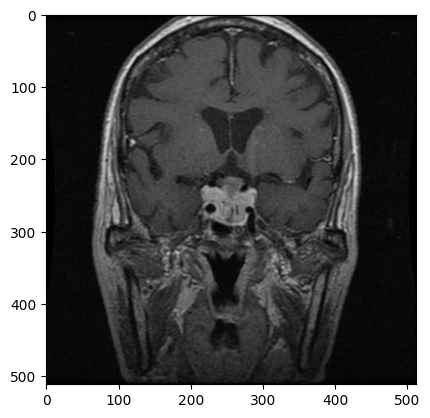

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [17]:
for image_class in os.listdir(training_path):
  for image in os.listdir(os.path.join(training_path, image_class)):
    image_path = os.path.join(training_path, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

In [18]:
for image_class in os.listdir(testing_path):
  for image in os.listdir(os.path.join(testing_path, image_class)):
    image_path = os.path.join(testing_path, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

# Loading data

Thr datset was already split into testing and training data so we do not need to define these later

In [50]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',  # Automatically infer labels from the directory structure
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.
Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [51]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()


In [52]:
Training_iterator

In [53]:
batch_training = Training_iterator.next()
batch_testing = Testing_iterator.next()

In [54]:
len(batch_training)

2

len of 2 as the image is 1 dimension and the label is the  other

In [55]:
batch_training[0].shape

(32, 256, 256, 3)

In [56]:
batch_training[1]

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [57]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


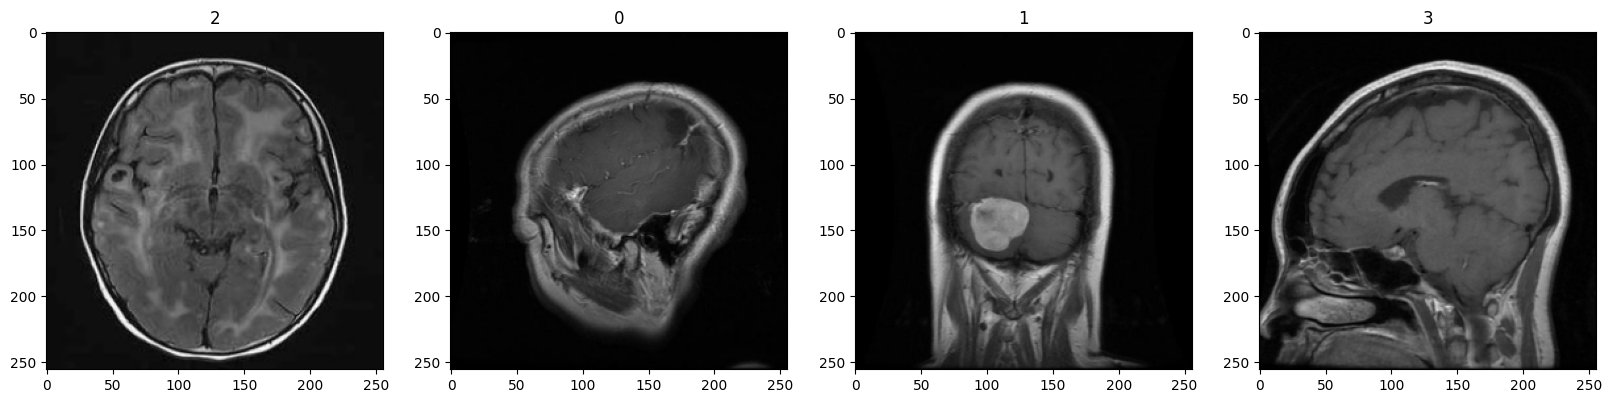

In [58]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


# Preprocessing Data

In [28]:
#Training_data = Training_data.map(lambda x, y: (x/255, y))
#Validation_data = Validation_data.map(lambda x, y: (x/255, y))
#Testing_data = Testing_data.map(lambda x, y: (x/255, y))
### X is Images
### Y is Labels


In [29]:
# @tf.function
# def preprocess_data(x, y):
#     x = x / 255.0  # Normalize the pixel values
#     y = tf.py_function(lambda y: tf.keras.utils.to_categorical(y, num_classes=4), [y], tf.float32)  # One-hot encode labels
#     return x, y
#     return x, y

# Training_data = Training_data.map(preprocess_data)
# Validation_data = Validation_data.map(preprocess_data)
# Testing_data = Testing_data.map(preprocess_data)

In [59]:
num_classes = 4  # Adjust based on your number of classes

# Load the training dataset
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the validation dataset
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))


In [30]:
# # Convert labels to one-hot encoding
# num_classes = 4  # Adjust based on your number of classes

# # Disable graph execution to use eager execution
# tf.config.run_functions_eagerly(True)

# # Define a custom function to convert symbolic tensor to numpy array
# def convert_to_numpy(x):
#     return tf.keras.backend.get_value(x)

# Training_data = Training_data.map(lambda x, y: (x, to_categorical(convert_to_numpy(y), num_classes=num_classes)))
# Validation_data = Validation_data.map(lambda x, y: (x, to_categorical(convert_to_numpy(y), num_classes=num_classes)))
# Testing_data = Testing_data.map(lambda x, y: (x, to_categorical(convert_to_numpy(y), num_classes=num_classes)))

# # Enable graph execution
# tf.config.run_functions_eagerly(False)

In [60]:
Training_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [61]:
batch_training = Training_data.as_numpy_iterator().next()
batch_testing = Testing_data.as_numpy_iterator().next()


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


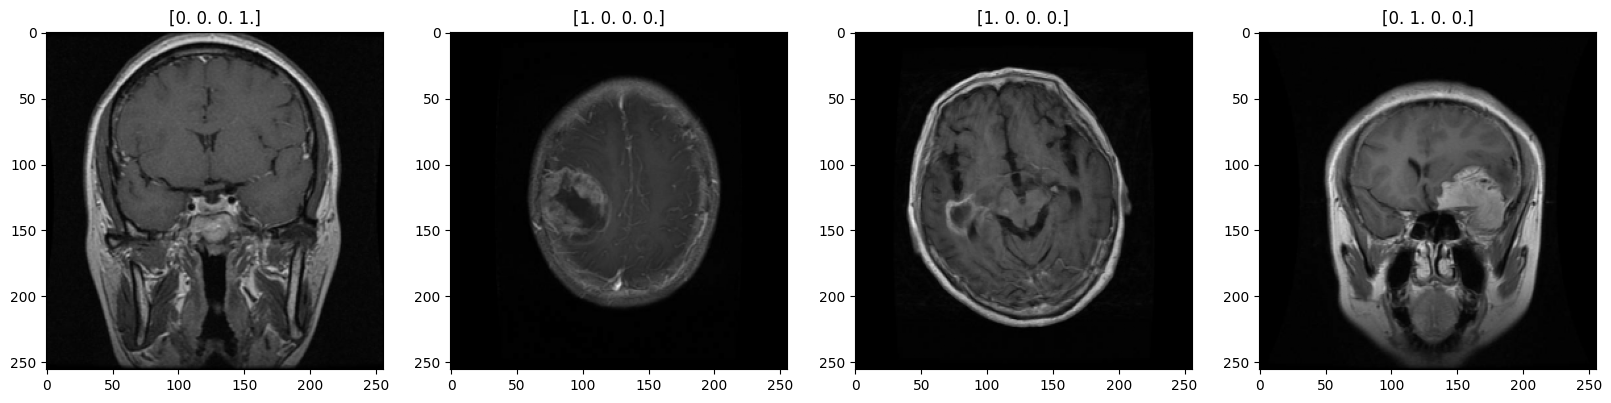

In [62]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   [1,0,0,0] : Glioma Tumor
-   [0,1,0,0]  : Meningioma Tumor
-   [0,0,1,0]  : No Tumor
-   [0,0,0,1]  : Pituitary Tumor


# Deep Model

In [34]:
# google how to use dropout


In [69]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(4, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(256, activation = 'relu'))

# Final layer that gives a single output and represets the label
model.add(Dense(4, activation = 'softmax'))

In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 4)         1156      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 4)        

#### Training

In [73]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [74]:
hist = model.fit(Training_data, epochs = 50, validation_data = Validation_data, callbacks = [tensorboard_callback])

Epoch 1/50
73/73 [==============================] - 16s 187ms/step - loss: 1.0255 - accuracy: 0.5619 - val_loss: 0.8262 - val_accuracy: 0.6529
Epoch 2/50
73/73 [==============================] - 15s 189ms/step - loss: 0.6570 - accuracy: 0.7212 - val_loss: 0.7267 - val_accuracy: 0.7010
Epoch 3/50
73/73 [==============================] - 14s 184ms/step - loss: 0.4633 - accuracy: 0.8174 - val_loss: 0.5175 - val_accuracy: 0.7887
Epoch 4/50
73/73 [==============================] - 13s 173ms/step - loss: 0.3179 - accuracy: 0.8746 - val_loss: 0.4310 - val_accuracy: 0.8333
Epoch 5/50
73/73 [==============================] - 12s 161ms/step - loss: 0.1896 - accuracy: 0.9330 - val_loss: 0.5246 - val_accuracy: 0.8196
Epoch 6/50
73/73 [==============================] - 14s 184ms/step - loss: 0.1236 - accuracy: 0.9540 - val_loss: 0.5587 - val_accuracy: 0.8419
Epoch 7/50
73/73 [==============================] - 12s 150ms/step - loss: 0.1207 - accuracy: 0.9656 - val_loss: 0.5239 - val_accuracy: 0.8488

In [ ]:
#tf.debugging.disable_traceback_filtering()

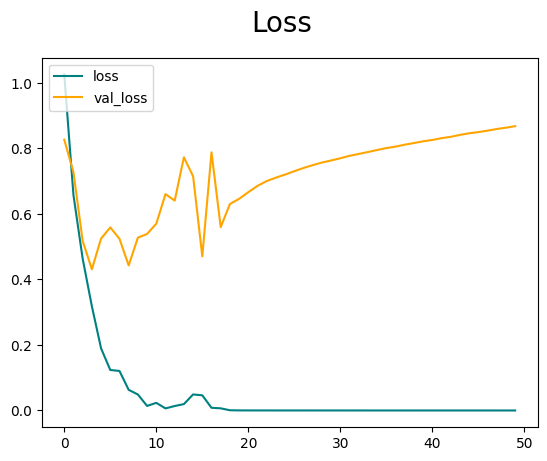

In [75]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

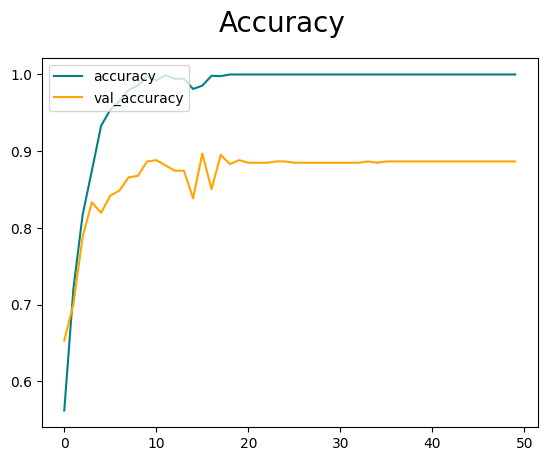

In [76]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()